In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import talos as ta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.optimizers import Adam, Nadam, RMSprop
from keras.callbacks import EarlyStopping,TensorBoard,ModelCheckpoint
from sklearn.metrics import mean_squared_error
from keras.losses import mean_squared_error
from keras.activations import relu, elu, softmax

Using TensorFlow backend.


In [2]:
data = pd.read_csv('galaxyS8_DE_21.240564489661963%.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6472 entries, 0 to 6471
Data columns (total 9 columns):
timestamp      6472 non-null object
category       6472 non-null object
cleanName      6472 non-null object
country        6472 non-null object
market_name    6472 non-null object
memory         6472 non-null object
name           6472 non-null object
price          6472 non-null float64
url            6472 non-null object
dtypes: float64(1), object(8)
memory usage: 455.1+ KB


In [4]:
data.head()

,timestamp,category,cleanName,country,market_name,memory,name,price,url
0,2017-12-21 08:41:08,Phone,Galaxy S8 Plus,DE,Galaxy S8 Plus,64GB,"Samsung Galaxy S8+ Smartphone (6,2 Zoll (15,8 ...",659.9,https://www.amazon.de/Samsung-Smartphone-Touch...
1,2017-12-20 18:31:39,Phone,Galaxy S8 Plus,DE,Galaxy S8 Plus,64GB,"Samsung Galaxy S8+ Smartphone (6,2 Zoll (15,8 ...",642.0,https://www.amazon.de/Samsung-Smartphone-Touch...
2,2017-12-20 18:54:35,Phone,Galaxy S8 Plus,DE,Galaxy S8 Plus,64GB,"Samsung Galaxy S8+ Smartphone (6,2 Zoll (15,8 ...",659.9,https://www.amazon.de/Samsung-Smartphone-Touch...
3,2017-12-20 18:16:22,Phone,Galaxy S8 Plus,DE,Galaxy S8 Plus,64GB,"Samsung Galaxy S8+ Smartphone (6,2 Zoll (15,8 ...",642.0,https://www.amazon.de/Samsung-Smartphone-Touch...
4,2017-12-20 14:44:18,Phone,Galaxy S8 Plus,DE,Galaxy S8 Plus,64GB,"Samsung Galaxy S8+ Smartphone (6,2 Zoll (15,8 ...",585.0,https://www.amazon.de/Samsung-Smartphone-Touch...


In [5]:
dataset = data[['timestamp', 'price']]

In [6]:
dataset.head()

,timestamp,price
0,2017-12-21 08:41:08,659.9
1,2017-12-20 18:31:39,642.0
2,2017-12-20 18:54:35,659.9
3,2017-12-20 18:16:22,642.0
4,2017-12-20 14:44:18,585.0


In [7]:
dataset.isnull().sum()

timestamp    0
price        0
dtype: int64

In [15]:
def ConvertToTimeSeries(DF,window):
    DF.index= pd.to_datetime(DF['timestamp'])
    DF=DF.resample("6H").mean()
    DF.sort_index(inplace=True)
    
    DF['t'] = [x for x in DF['price']]
    DF['t-1'] = DF['t'].shift(1)
    for i in range(1,window):
        DF['t-'+str(i+1)] = DF['t-'+str(i)].shift(1)
        
    DF.dropna(inplace=True)
    DF.drop(['t'], 1 , inplace=True)
    
    return(DF)

In [16]:
price_samsg = ConvertToTimeSeries(dataset,4)

In [17]:
price_samsg.head()

,price,t-1,t-2,t-3,t-4
timestamp,,,,,
2017-12-10 00:00:00,660.663226,649.769091,675.176364,649.000000,756.590000
2017-12-10 06:00:00,653.350000,660.663226,649.769091,675.176364,649.000000
2017-12-10 12:00:00,685.348400,653.350000,660.663226,649.769091,675.176364
2017-12-10 18:00:00,656.434091,685.348400,653.350000,660.663226,649.769091
2017-12-11 00:00:00,660.020000,656.434091,685.348400,653.350000,660.663226


In [18]:
#Ajustement du module d'apprentissage
def fitLSTM(DF,window):
    df= ConvertToTimeSeries(DF,window)
    
    X = np.array(df.drop(['price'],1))
    
    y = np.array(df['price'])
    X = scale(X)
    
    return X,y


In [19]:
X,y = fitLSTM(dataset,4)
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.2, shuffle=False)

In [20]:
X_train.shape,X_test.shape

((81, 4), (21, 4))

In [21]:
#Ajustement des dimensions des Inputs
X_train=np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
input_size=X_train.shape[0]


In [22]:
X_train.shape,X_test.shape

((81, 4, 1), (21, 4, 1))

In [23]:
#Creation du model LSTM
model = Sequential()
model.add(LSTM(300,return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(300))
model.add(Dense(1))
adam = Adam(lr=0.005)

model.compile(loss='mean_squared_error',optimizer='adam')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 4, 300)            362400    
_________________________________________________________________
lstm_2 (LSTM)                (None, 300)               721200    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 301       
Total params: 1,083,901
Trainable params: 1,083,901
Non-trainable params: 0
_________________________________________________________________


In [54]:
model_name='GALAXY'

checkpointer = ModelCheckpoint(
    filepath=os.path.join(model_name + '.hdf5'),
    monitor='val_loss', verbose=1, save_best_only=True, mode='min', period=1)

early_stop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, mode='min', verbose=1)

tensorboard = TensorBoard(log_dir='./Graph/'+model_name,
                          histogram_freq=1,
                          write_grads=True,
                          # batch_size=batch_size,
                          write_graph=True,
                          write_images=True)

In [55]:
cp=ModelCheckpoint('galaxy_lstm.hdf5',monitor='val_loss',verbose=1,save_best_only=True)

In [56]:
history = model.fit(X_train, y_train, batch_size=1, epochs=100, validation_data=(X_test, y_test), callbacks=[cp])

Train on 81 samples, validate on 21 samples
Epoch 1/100
81/81 [==============================] - 8s 99ms/step - loss: 475281.4236 - val_loss: 399331.0000

Epoch 00001: val_loss improved from inf to 399331.00000, saving model to galaxy_lstm.hdf5
Epoch 2/100
81/81 [==============================] - 4s 53ms/step - loss: 426556.4541 - val_loss: 365343.1042

Epoch 00002: val_loss improved from 399331.00000 to 365343.10417, saving model to galaxy_lstm.hdf5
Epoch 3/100
81/81 [==============================] - 5s 61ms/step - loss: 393078.9061 - val_loss: 335321.6711

Epoch 00003: val_loss improved from 365343.10417 to 335321.67113, saving model to galaxy_lstm.hdf5
Epoch 4/100
81/81 [==============================] - 6s 76ms/step - loss: 362762.4286 - val_loss: 307900.8683

Epoch 00004: val_loss improved from 335321.67113 to 307900.86830, saving model to galaxy_lstm.hdf5
Epoch 5/100
81/81 [==============================] - 7s 87ms/step - loss: 334812.4497 - val_loss: 282526.3467

Epoch 00005: v

81/81 [==============================] - 7s 82ms/step - loss: 2810.5842 - val_loss: 2111.6236

Epoch 00089: val_loss did not improve from 1336.61682
Epoch 90/100
81/81 [==============================] - 5s 68ms/step - loss: 2809.9595 - val_loss: 1714.5562

Epoch 00090: val_loss did not improve from 1336.61682
Epoch 91/100
81/81 [==============================] - 6s 72ms/step - loss: 2728.6302 - val_loss: 1498.7993

Epoch 00091: val_loss did not improve from 1336.61682
Epoch 92/100
81/81 [==============================] - 6s 75ms/step - loss: 2673.6616 - val_loss: 2304.9378

Epoch 00092: val_loss did not improve from 1336.61682
Epoch 93/100
81/81 [==============================] - 6s 72ms/step - loss: 2744.8616 - val_loss: 1731.8344

Epoch 00093: val_loss did not improve from 1336.61682
Epoch 94/100
81/81 [==============================] - 6s 76ms/step - loss: 2734.1204 - val_loss: 1542.9518

Epoch 00094: val_loss did not improve from 1336.61682
Epoch 95/100
81/81 [=====================

dict_keys(['val_loss', 'loss'])


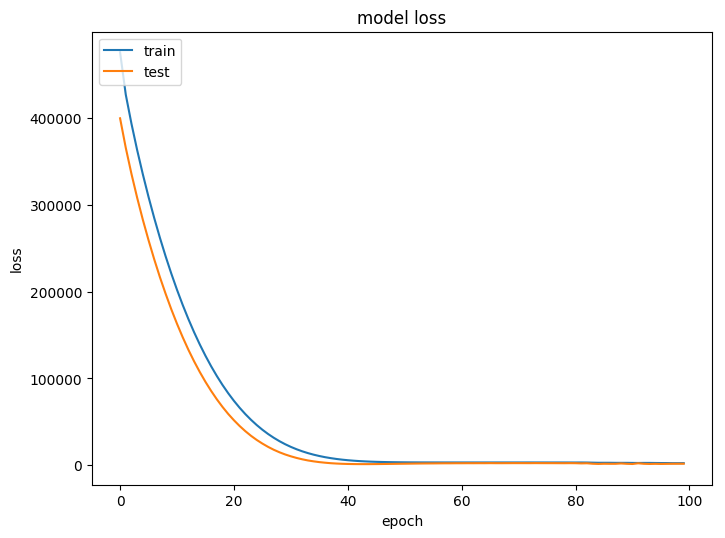

In [59]:
# list all data in history
print(history.history.keys())
'''plt.figure(figsize=(8, 6), dpi=100)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(os.path.join('model accuracy 3.png'))
plt.show()'''
# summarize history for loss
plt.figure(figsize=(8, 6), dpi=100)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(os.path.join('model loss 3.png'))
plt.show()

In [60]:
import sklearn
def RMSE(y_test,Y_new):
    return np.sqrt(sklearn.metrics.mean_squared_error(y_test-Y_new))

In [61]:
Y_new = model.predict(X_test)
rmse = np.sqrt(sklearn.metrics.mean_squared_error(y_test,Y_new))
print(rmse)

42.29948974488621


In [62]:
best_model = load_model('galaxy_lstm.hdf5')

In [63]:
Y_new = best_model.predict(X_test)
rmse = np.sqrt(sklearn.metrics.mean_squared_error(y_test,Y_new))
print(rmse)

36.55974921867143


In [107]:
def galaxy_model(X_train, y_train, X_test, y_test, params):

    model = Sequential()
    model.add(LSTM(params['LSTM1'], return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(params['LSTM2']))
    model.add(Dense(1))

    model.compile(optimizer=params['optimizer'](),
                  loss='mean_squared_error', metrics=['acc'])
    
    early_stopping_callback = EarlyStopping(monitor='val_loss', patience=params['epochs'])

    history = model.fit(X_train, y_train,
                    batch_size=params['batch_size'],
                    epochs=params['epochs'],
                    verbose=0,
                    validation_data=[X_test, y_test],
                    callbacks=[checkpointer, early_stopping_callback])

    return history

In [108]:
p = {'lr': [2, 10, 30],
     'LSTM1':[200, 300, 400],
     'LSTM2':[200, 300, 400],
     'batch_size': [1, 2, 3, 4, 5, 6],
     'epochs': [100, 200],
     'optimizer': [Adam, RMSprop],
     'losses': [mean_squared_error]}


In [109]:
import hyperio as hy

In [110]:
h = hy.Hyperio(X_train, y_train,
          params=p,
          dataset_name='first_test',
          experiment_no='1',
          model=galaxy_model,
          grid_downsample=0.01)


Epoch 00001: val_loss did not improve from 419884.03125

Epoch 00002: val_loss did not improve from 419884.03125

Epoch 00003: val_loss did not improve from 419884.03125

Epoch 00004: val_loss did not improve from 419884.03125

Epoch 00005: val_loss did not improve from 419884.03125

Epoch 00006: val_loss did not improve from 419884.03125

Epoch 00007: val_loss did not improve from 419884.03125

Epoch 00008: val_loss did not improve from 419884.03125

Epoch 00009: val_loss did not improve from 419884.03125

Epoch 00010: val_loss did not improve from 419884.03125

Epoch 00011: val_loss did not improve from 419884.03125

Epoch 00012: val_loss did not improve from 419884.03125

Epoch 00013: val_loss did not improve from 419884.03125

Epoch 00014: val_loss did not improve from 419884.03125

Epoch 00015: val_loss did not improve from 419884.03125

Epoch 00016: val_loss did not improve from 419884.03125

Epoch 00017: val_loss did not improve from 419884.03125

Epoch 00018: val_loss did not 

AttributeError: 'Hyperio' object has no attribute '_y_range'

In [111]:
hs = ta.Scan(X_train, y_train,
          params=p,
          dataset_name='second_test',
          experiment_no='2',
          model=galaxy_model,
          grid_downsample=0.5)


Epoch 00001: val_loss did not improve from 419884.03125

Epoch 00002: val_loss did not improve from 419884.03125

Epoch 00003: val_loss did not improve from 419884.03125

Epoch 00004: val_loss did not improve from 419884.03125

Epoch 00005: val_loss did not improve from 419884.03125

Epoch 00006: val_loss did not improve from 419884.03125

Epoch 00007: val_loss did not improve from 419884.03125

Epoch 00008: val_loss did not improve from 419884.03125

Epoch 00009: val_loss did not improve from 419884.03125

Epoch 00010: val_loss did not improve from 419884.03125

Epoch 00011: val_loss did not improve from 419884.03125

Epoch 00012: val_loss did not improve from 419884.03125

Epoch 00013: val_loss did not improve from 419884.03125

Epoch 00014: val_loss did not improve from 419884.03125

Epoch 00015: val_loss did not improve from 419884.03125

Epoch 00016: val_loss did not improve from 419884.03125

Epoch 00017: val_loss did not improve from 419884.03125

Epoch 00018: val_loss did not 


Epoch 00145: val_loss did not improve from 419884.03125

Epoch 00146: val_loss did not improve from 419884.03125

Epoch 00147: val_loss did not improve from 419884.03125

Epoch 00148: val_loss did not improve from 419884.03125

Epoch 00149: val_loss did not improve from 419884.03125

Epoch 00150: val_loss did not improve from 419884.03125

Epoch 00151: val_loss did not improve from 419884.03125

Epoch 00152: val_loss did not improve from 419884.03125

Epoch 00153: val_loss did not improve from 419884.03125

Epoch 00154: val_loss did not improve from 419884.03125

Epoch 00155: val_loss did not improve from 419884.03125

Epoch 00156: val_loss did not improve from 419884.03125

Epoch 00157: val_loss did not improve from 419884.03125

Epoch 00158: val_loss did not improve from 419884.03125

Epoch 00159: val_loss did not improve from 419884.03125

Epoch 00160: val_loss did not improve from 419884.03125

Epoch 00161: val_loss did not improve from 419884.03125

Epoch 00162: val_loss did not 

UnboundLocalError: local variable '_hr_out' referenced before assignment